#                                            Reverse Image Search

In [80]:

import os
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
import shutil

In [81]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

Create the keras image data generator object and extract the features for the images using Resnet50 predict_generator method.

In [82]:
batch_size = 64
root_dir = 'PokemonData'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

#feature_list = model.predict_generator(datagen, num_epochs,verbose = 1)
#if os.path.isdir('npyModels') == "False": os.mkdir('npyModels')
#np.save('npyModels/base_model.npy', feature_list)
feature_list = np.load('npyModels/base_model.npy')

Found 6820 images belonging to 150 classes.


In [83]:
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Num images   =  6820
Shape of feature_list =  (6820, 2048)


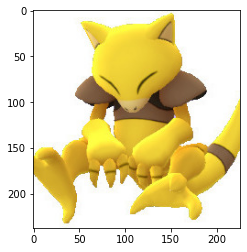

In [84]:
plt.imshow(plt.imread('PokemonData/Abra/2eb2a528f9a247358452b3c740df69a0.jpg'))
plt.show()

We have 9144 images in our dataset. Each image is converted into a 2048 feature vector.

In [85]:
# Get full path for all the images in our dataset

filenames = [root_dir + '/' + s for s in datagen.filenames]

In [86]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

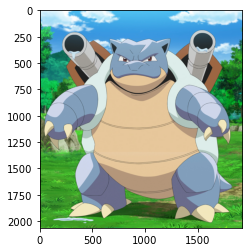

In [87]:
plt.imshow(plt.imread("TestImages/Gary_Blastoise.webp"))
plt.show()

In [88]:
img_path = 'TestImages/Gary_Blastoise.webp'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)


In [89]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


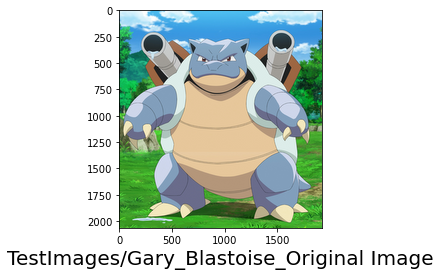

********* Predictions ***********


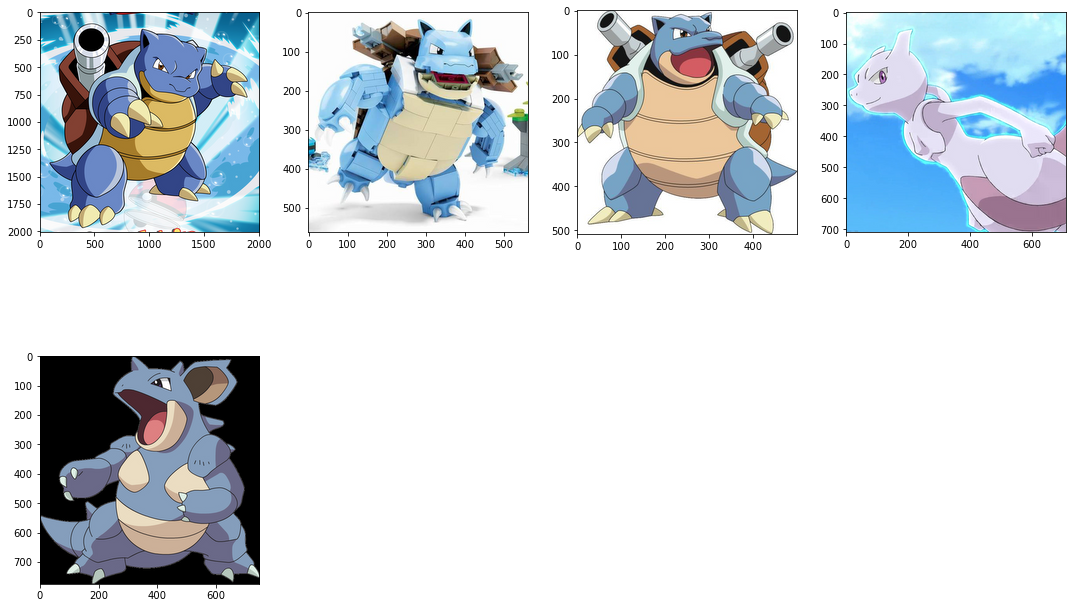

In [90]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            #print (filenames[index])
            try:
                plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
                plotnumber+=1
            except SyntaxError as error:
                print(error)
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [91]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [92]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


********* Predictions  after PCA ***********


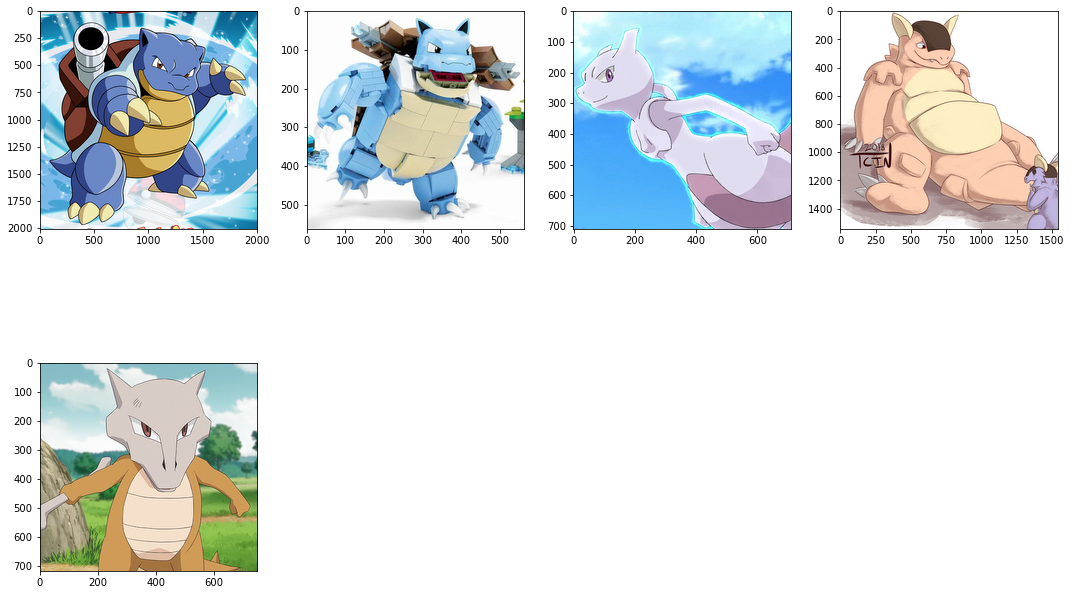

In [93]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions  after PCA ***********')
similar_images(indices[0])

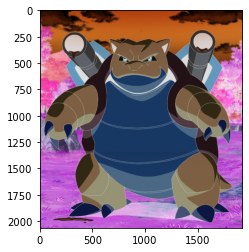

In [94]:
im = PIL.Image.open('TestImages/Gary_Blastoise.webp')
im_invert = PIL.ImageOps.invert(im)
im_invert.save('TestImages/Gary_Blastoise_invert.webp', quality=95)
plt.imshow(plt.imread('TestImages/Gary_Blastoise_invert.webp'))
plt.show()

In [95]:
img_path = 'TestImages/Gary_Blastoise_invert.webp'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)


In [96]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


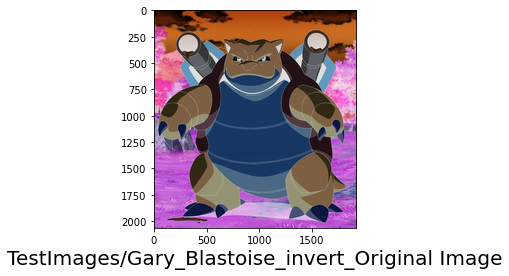

********* Predictions ***********


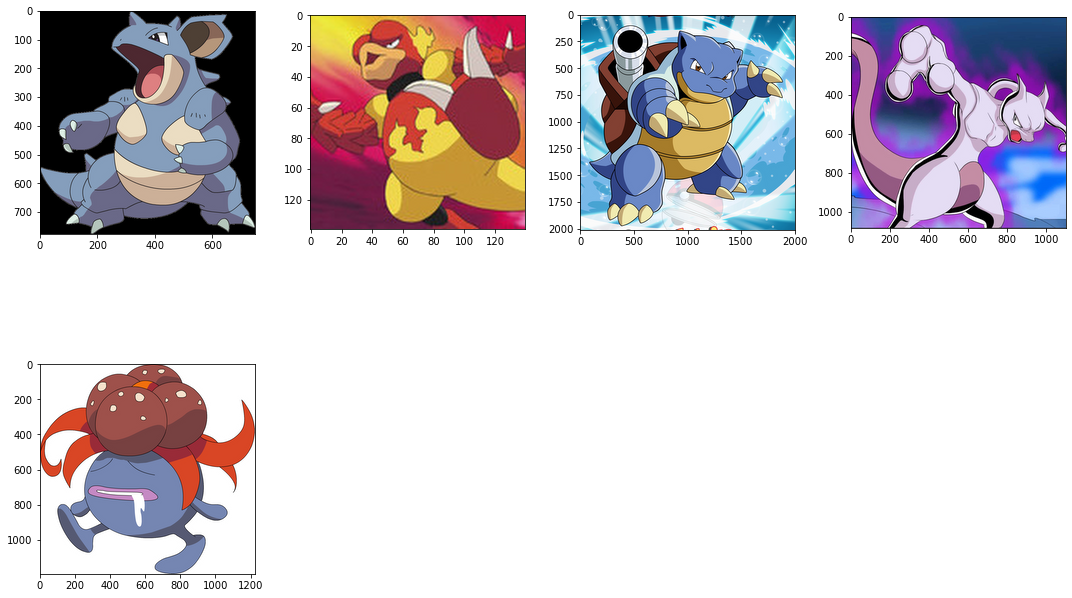

In [97]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

(1, 5)


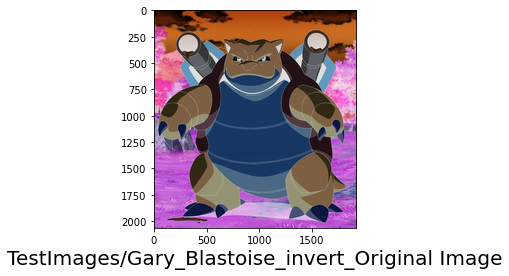

********* Predictions after PCA ***********


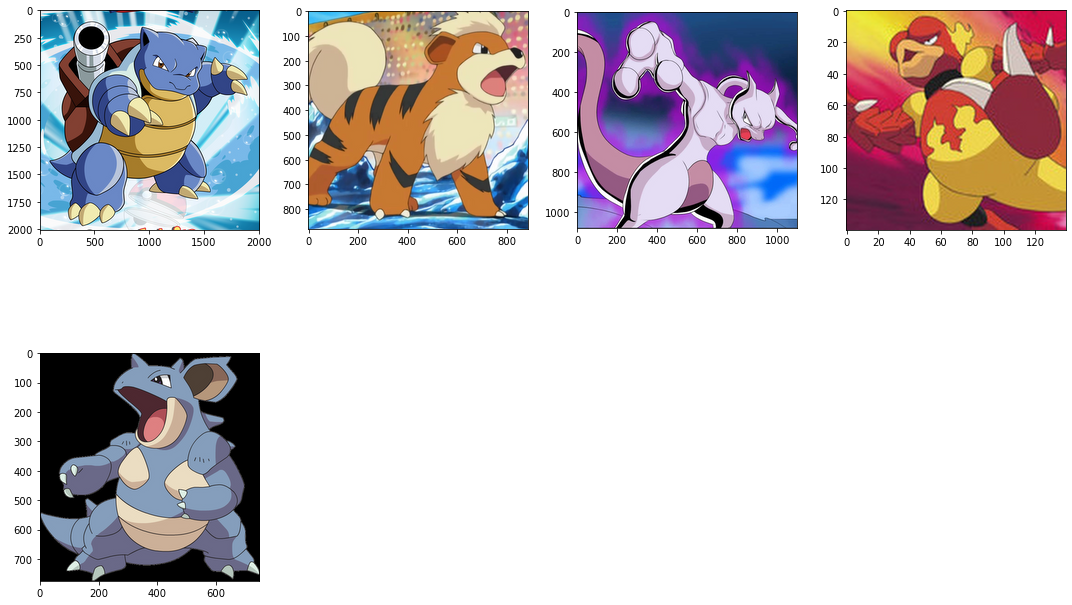

In [98]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions after PCA ***********')
similar_images(indices[0])

In [99]:
# Making inverted files and saving them to the newly made directories
count = 0
if not os.path.exists('PokemonData_Inverted'): os.mkdir('PokemonData_Inverted')
for path, _, files in os.walk('PokemonData'):
    new_path = os.path.join('PokemonData_Inverted', os.path.basename(path))
    if os.path.basename(path) != 'PokemonData' and not os.path.exists(new_path):
        os.makedirs(new_path)
    for file in files:
        if not os.path.exists(os.path.join(new_path, 'inverted_' + file)):
            try:
                im = PIL.Image.open(os.path.join(path, file))
                im_invert = PIL.ImageOps.invert(im)
                im_invert.save(os.path.join(new_path, 'inverted_' + file), quality=95)
            except OSError as error:
                print (os.path.join(path, file))
                count += 1
            except ValueError as error:
                print (error)
                count += 1
            except NotImplementedError as error:
                print (error)
                count += 1

print ("Images that could not be inverted: ", count)
        

PokemonData/.DS_Store
PokemonData/Zapdos/c99b2d19544c4cbbacd7711ade660279.svg
PokemonData/Alolan Sandslash/AlolanSandslashDuel475.png
PokemonData/Alolan Sandslash/Alolan Sandslash.png
PokemonData/Alolan Sandslash/asandslashbattle1.png
PokemonData/Alolan Sandslash/high_quality_wallpaper_HD_1080_IDS_1158914.png
PokemonData/Alolan Sandslash/WV4lqZqCl7.png
PokemonData/Graveler/3fe3c6a0bbd14de89092d2c675f743c1.svg
PokemonData/Magneton/45e434d002bd44eeb1acbc2decc8ee0f.svg
unknown file extension: .asp
PokemonData/Tentacruel/d6fb0a3046364ea2b49525c6f6b966e5.svg
PokemonData/Scyther/a8734f10941a4deb95fcf7388e4fe8e2.svg
PokemonData/Cloyster/ff270ebfab0f46b3b05c3fecd6a15ef9.svg
PokemonData/Squirtle/00000010.png
PokemonData/Squirtle/00000005.png
PokemonData/Squirtle/00000006.png
PokemonData/Squirtle/00000016.png
PokemonData/Squirtle/00000003.png
PokemonData/Squirtle/00000017.png
PokemonData/Squirtle/00000000.png
PokemonData/Squirtle/00000051.png
PokemonData/Squirtle/00000044.png
PokemonData/Squirtl

In [100]:
batch_size = 64
root_dir = 'PokemonData_inverted'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

#feature_list = model.predict_generator(datagen, num_epochs,verbose = 1)
#if os.path.isdir('npyModels') == "False": os.mkdir('npyModels')
#np.save('npyModels/inverted_model.npy', feature_list)
feature_list = np.load('npyModels/inverted_model.npy')

Found 6711 images belonging to 150 classes.


In [101]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [102]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

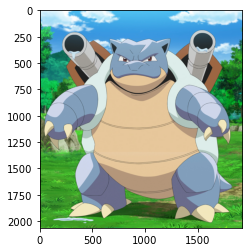

In [103]:
plt.imshow(plt.imread("TestImages/Gary_Blastoise.webp"))
plt.show()

In [104]:
img_path = 'TestImages/Gary_Blastoise.webp'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

In [105]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


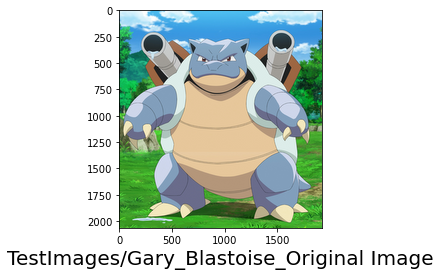

********* Predictions ***********


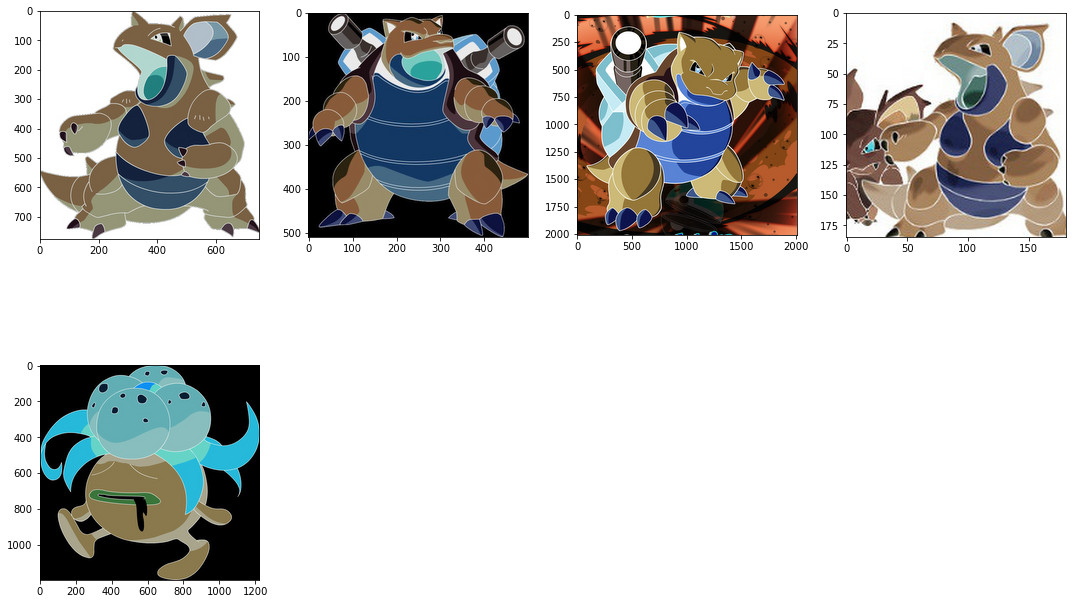

In [106]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            #print (filenames[index])
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [107]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [108]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


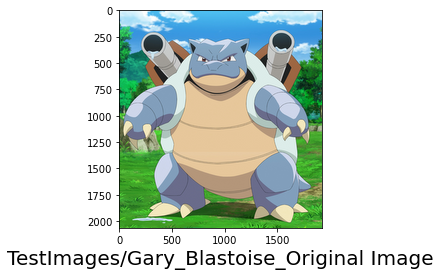

********* Predictions  after PCA ***********


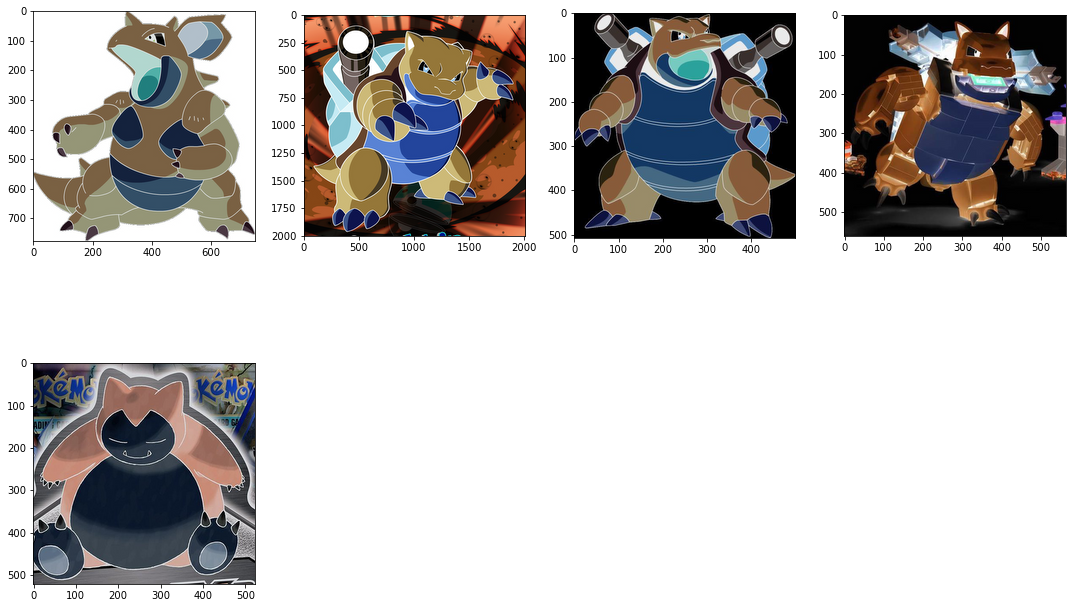

In [109]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions  after PCA ***********')
similar_images(indices[0])

In [123]:
source_dir = "PokemonData"
destination_dir = "PokemonData_with_Invert"
shutil.copytree(source_dir, destination_dir)

'PokemonData_with_Invert'

In [125]:
count = 0
for path, _, files in os.walk('PokemonData'):
    for file in files:
        new_path = os.path.join('PokemonData_with_Invert', os.path.basename(path))
        if not os.path.exists(os.path.join(new_path, 'inverted_' + file)):
            try:
                im = PIL.Image.open(os.path.join(path, file))
                im_invert = PIL.ImageOps.invert(im)
                im_invert.save(os.path.join(new_path, 'inverted_' + file), quality=95)
            except OSError as error:
                print (os.path.join(path, file))
                count += 1
            except ValueError as error:
                print (error)
                count += 1
            except NotImplementedError as error:
                print (error)
                count += 1

print ("Images that could not be inverted: ", count)

PokemonData/.DS_Store
PokemonData/Zapdos/c99b2d19544c4cbbacd7711ade660279.svg
PokemonData/Alolan Sandslash/AlolanSandslashDuel475.png
PokemonData/Alolan Sandslash/Alolan Sandslash.png
PokemonData/Alolan Sandslash/asandslashbattle1.png
PokemonData/Alolan Sandslash/high_quality_wallpaper_HD_1080_IDS_1158914.png
PokemonData/Alolan Sandslash/WV4lqZqCl7.png
PokemonData/Graveler/3fe3c6a0bbd14de89092d2c675f743c1.svg
PokemonData/Magneton/45e434d002bd44eeb1acbc2decc8ee0f.svg
unknown file extension: .asp
PokemonData/Tentacruel/d6fb0a3046364ea2b49525c6f6b966e5.svg
PokemonData/Scyther/a8734f10941a4deb95fcf7388e4fe8e2.svg
PokemonData/Cloyster/ff270ebfab0f46b3b05c3fecd6a15ef9.svg
PokemonData/Squirtle/00000010.png
PokemonData/Squirtle/00000005.png
PokemonData/Squirtle/00000006.png
PokemonData/Squirtle/00000016.png
PokemonData/Squirtle/00000003.png
PokemonData/Squirtle/00000017.png
PokemonData/Squirtle/00000000.png
PokemonData/Squirtle/00000051.png
PokemonData/Squirtle/00000044.png
PokemonData/Squirtl

In [126]:
batch_size = 64
root_dir = 'PokemonData_with_Invert'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

# feature_list = model.predict_generator(datagen, num_epochs,verbose = 1)
# if os.path.isdir('npyModels') == "False": os.mkdir('npyModels')
# np.save('npyModels/combined_model.npy', feature_list)
feature_list = np.load('npyModels/combined_model.npy')

Found 13531 images belonging to 150 classes.


In [127]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [128]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

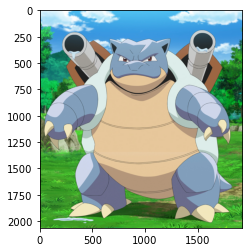

In [129]:
plt.imshow(plt.imread("TestImages/Gary_Blastoise.webp"))
plt.show()

In [130]:
img_path = 'TestImages/Gary_Blastoise.webp'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

In [131]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


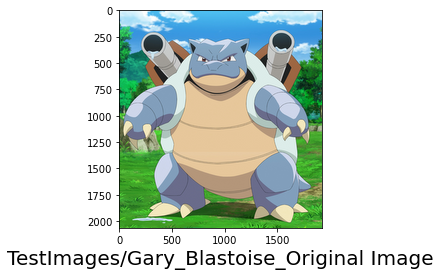

********* Predictions ***********
PokemonData_with_Invert/Blastoise/0f0c54a9457345ccb96a52038295887a.jpg
PokemonData_with_Invert/Nidoqueen/inverted_26a4771acc094634b0f9c9868d4746a5.jpg
PokemonData_with_Invert/Blastoise/1d18c0d07974465091b45383db76dda1.jpg
PokemonData_with_Invert/Blastoise/533971b02e5041dd9392b469762bdb45.jpg
PokemonData_with_Invert/Mewtwo/00000069.png


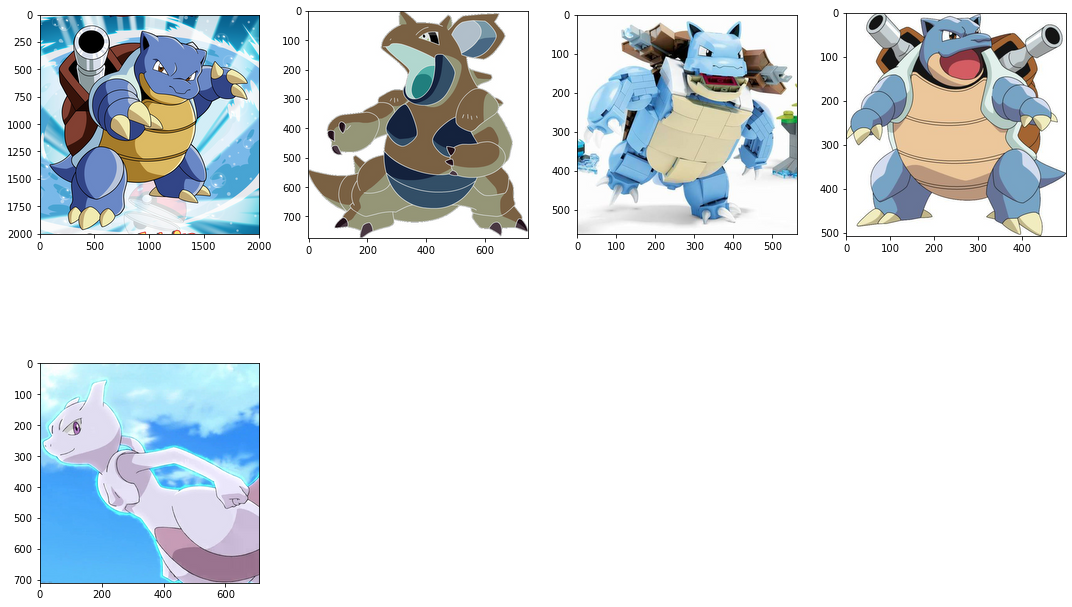

In [132]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            print (filenames[index])
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [133]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [134]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


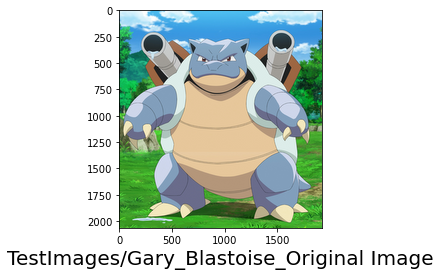

********* Predictions  after PCA ***********
PokemonData_with_Invert/Blastoise/0f0c54a9457345ccb96a52038295887a.jpg
PokemonData_with_Invert/Blastoise/1d18c0d07974465091b45383db76dda1.jpg
PokemonData_with_Invert/Nidoqueen/inverted_26a4771acc094634b0f9c9868d4746a5.jpg
PokemonData_with_Invert/Blastoise/inverted_0f0c54a9457345ccb96a52038295887a.jpg
PokemonData_with_Invert/Mewtwo/00000069.png


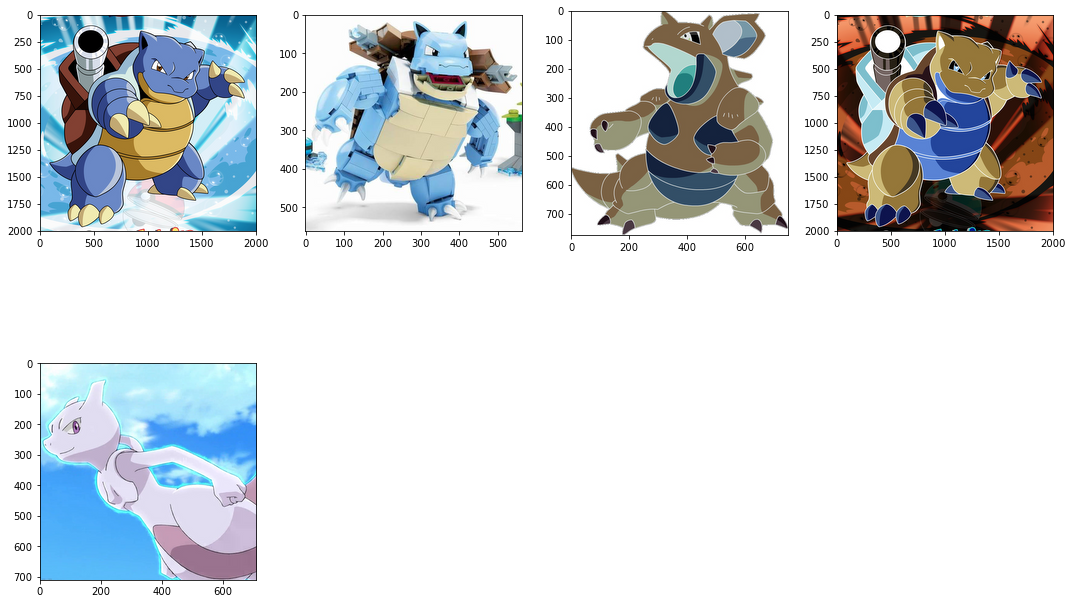

In [135]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions  after PCA ***********')
similar_images(indices[0])